In [1]:
install.packages("HistData")
library(HistData)

install.packages("FNN")
library(FNN)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)



This report presents an attempt to predict childHeight by combining the prediction of different models or also known as ensemble learning. Instead of picking several new models, I simply use the baseline model, linear regression, as one of the models and one of the simplest and best-known non-parametric methods, KNN regression, as the other one. In this experiment, I would like to see how far I can improve the accuracy of linear regression by taking the prediction by KNN regression into consideration before we conclude with the final predicted childHeight. Followings the the steps of the experiments:

1. Add a new variable gender_bin to allow knn to measure the distance of the father, mother, and also gender

In [12]:
data(GaltonFamilies)
gender_bin <- rep(0, nrow(GaltonFamilies))
gender_bin[GaltonFamilies$gender == 'male'] <- 1
GaltonFamilies <- data.frame(GaltonFamilies, gender_bin)

print(head(GaltonFamilies))

  family father mother midparentHeight children childNum gender childHeight
1    001   78.5   67.0           75.43        4        1   male        73.2
2    001   78.5   67.0           75.43        4        2 female        69.2
3    001   78.5   67.0           75.43        4        3 female        69.0
4    001   78.5   67.0           75.43        4        4 female        69.0
5    002   75.5   66.5           73.66        4        1   male        73.5
6    002   75.5   66.5           73.66        4        2   male        72.5
  gender_bin
1          1
2          0
3          0
4          0
5          1
6          1


2. Sample train and test set. Since there are multiple children sampled from each family, I further preprocess the traindata such that for each family there is only one child per gender. This is to prevent high leverage of a family or children from the same family .

In [21]:
n <- dim(GaltonFamilies)[1]
ntest <- 200
train <- sample(1:n, n-ntest, replace = FALSE) 

temp_traindata <- GaltonFamilies[train,c("family", "father", "mother", "gender_bin", "childHeight")]
traindata<-temp_traindata[0,]
for (f in unique(temp_traindata$family)){
    fam = subset(temp_traindata, family==f)
    for (g in unique(fam$gender_bin)){
        gen = subset(fam, gender_bin==g)
        df<-data.frame(mean(gen$father),mean(gen$mother), g, mean(gen$childHeight))
        names(df)<-c("father","mother","gender_bin","childHeight")
        traindata = rbind(traindata, df)
    }
}
testdata <- GaltonFamilies[-train,c("father", "mother", "gender_bin", "childHeight")]

print(head(temp_traindata[order(temp_traindata$family),]))
print(head(traindata))
print(head(testdata))

  family father mother gender_bin childHeight
3    001   78.5   67.0          0        69.0
1    001   78.5   67.0          1        73.2
6    002   75.5   66.5          1        72.5
8    002   75.5   66.5          0        65.5
7    002   75.5   66.5          0        65.5
5    002   75.5   66.5          1        73.5
  father mother gender_bin childHeight
1     69   68.5          1    72.00000
2     69   68.5          0    64.91667
3     70   67.0          1    69.00000
4     70   67.0          0    63.33333
5     68   64.0          0    64.00000
6     68   64.0          1    68.50000
   father mother gender_bin childHeight
2    78.5   67.0          0        69.2
4    78.5   67.0          0        69.0
11   75.0   64.0          1        70.5
14   75.0   64.0          0        64.5
19   75.0   58.5          0        66.5
20   75.0   58.5          0        62.5


3. Fit the baseline model and the knn regression using all the variables, namely father, mother, and gender_bin. The parameter of KNN is found by running a few experiments that achieves the best accuracy. The 3 nearest neighbors are extracted beforehand for future usage.

In [4]:
fit_baseline <- lm(childHeight ~ ., data = traindata)

knn_k = 3
k <- knn(
    traindata[,c("father", "mother", "gender_bin")], 
    testdata[,c("father", "mother", "gender_bin")], 
    traindata[,"childHeight"], 
    k = knn_k)
indices = attr(k, "nn.index")
height_baseline_pred <- c(0,ntest)

print(head(indices))

     [,1] [,2] [,3]
[1,]  147  148   89
[2,]  286  320  287
[3,]  286  320  287
[4,]   84   85  319
[5,]   85   84  319
[6,]  267  301  266


4. Predict the childHeight and measure the MSE. Although KNN would try to find the nearest neighbors and I have set the gender_bin as one of the distance, it could still found that the nearest neighbor is of a different gender. In this case, there may be no nearest neighbors of the same gender. As mentioned in lecture, male is generally 8% taller than female. Thus, the prediction by KNN may need to be adjusted to match the gender of the testdata. In this experiment, I try to apply different weightings based on the number of different gender of those of the nearest neighbors and the testdata. Finally, I use the weighted average to combine the prediction from the baseline model and KNN regression, where each weight is also found by experiment. 

In [5]:
for (j in 1:ntest){
    pred = predict(fit_baseline,testdata[j,])
    diff_gen = abs(knn_k*testdata[j,]$gender_bin - sum(traindata[indices[j,],]$gender_bin))
    if (diff_gen > (knn_k-1)){
        alpha = 1
    }
    else if (diff_gen > (knn_k-2)){
        alpha = 0.99
    }
    else if (diff_gen > (knn_k-3)){
        alpha = 0.8
    }
    else{
        alpha = 0.76
    }
    height_baseline_pred[j] <- alpha*pred + (1-alpha)*mean(traindata[indices[j,],]$childHeight)
}

print(mean((testdata$childHeight - height_baseline_pred)^2))

[1] 4.681863


In the plot below, we observe that we can improve the baseline model by combining the prediction with those of KNN regression.

# based on 100 replications

In [7]:
nrep <- 100
MSE_bonus <- data.frame(matrix(0,nrep,1))
names(MSE_bonus) <- c("lm~knn")

set.seed(1)

for (i in 1:nrep){
    #1
    data(GaltonFamilies)
    gender_bin <- rep(0, nrow(GaltonFamilies))
    gender_bin[GaltonFamilies$gender == 'male'] <- 1
    GaltonFamilies <- data.frame(GaltonFamilies, gender_bin)

    #2
    n <- dim(GaltonFamilies)[1]
    ntest <- 200
    train <- sample(1:n, n-ntest, replace = FALSE) 

    temp_traindata <- GaltonFamilies[train,c("family", "father", "mother", "gender_bin", "childHeight")]
    traindata<-temp_traindata[0,]
    for (f in unique(temp_traindata$family)){
        fam = subset(temp_traindata, family==f)
        for (g in unique(fam$gender_bin)){
            gen = subset(fam, gender_bin==g)
            df<-data.frame(mean(gen$father),mean(gen$mother), g, mean(gen$childHeight))
            names(df)<-c("father","mother","gender_bin","childHeight")
            traindata = rbind(traindata, df)
        }
    }
    testdata <- GaltonFamilies[-train,c("father", "mother", "gender_bin", "childHeight")]

    #3
    fit_baseline <- lm(childHeight ~ ., data = traindata)

    knn_k = 3
    k <- knn(
        traindata[,c("father", "mother", "gender_bin")], 
        testdata[,c("father", "mother", "gender_bin")], 
        traindata[,"childHeight"], 
        k = knn_k)
    indices = attr(k, "nn.index")
    height_baseline_pred <- c(0,ntest)

    #4
    for (j in 1:ntest){
        pred = predict(fit_baseline,testdata[j,])
        diff_gen = abs(knn_k*testdata[j,]$gender_bin - sum(traindata[indices[j,],]$gender_bin))
        if (diff_gen > (knn_k-1)){
            alpha = 1
        }
        else if (diff_gen > (knn_k-2)){
            alpha = 0.99
        }
        else if (diff_gen > (knn_k-3)){
            alpha = 0.8
        }
        else{
            alpha = 0.76
        }
        height_baseline_pred[j] <- alpha*pred + (1-alpha)*mean(traindata[indices[j,],]$childHeight)
    }

    MSE_bonus[i,1] <- mean((testdata$childHeight - height_baseline_pred)^2)
}
sum(MSE_bonus)/nrep

[1] 4.573529

In [8]:
data(GaltonFamilies)
set.seed(1) # set random seed for the reproduciable purpose 
nrep <- 100
n <- dim(GaltonFamilies)[1]
ntest <- 200
MSE <- data.frame(matrix(0,nrep,1))
names(MSE) <- c("lm")
for (i in 1:nrep){
# partion training data and testing data
train <- sample(1:n, n-ntest, replace = FALSE) 
traindata <- GaltonFamilies[train,]
testdata <- GaltonFamilies[-train,]
# Fit a baseline model
fit_baseline <- lm(childHeight~gender + midparentHeight, traindata)
# make prediction based on the fitted model
height_baseline_pred <- predict(fit_baseline,testdata)
# Evaluate model performance
MSE[i,1] <- mean((testdata$childHeight - height_baseline_pred)^2)
# Warning: You should not use childNum as a predictor in your model
# because children within a family are listed in decreasing order of height 
# for boys followed by girls
}
sum(MSE)/nrep #the mean squared errors of the baseline model

[1] 4.694932

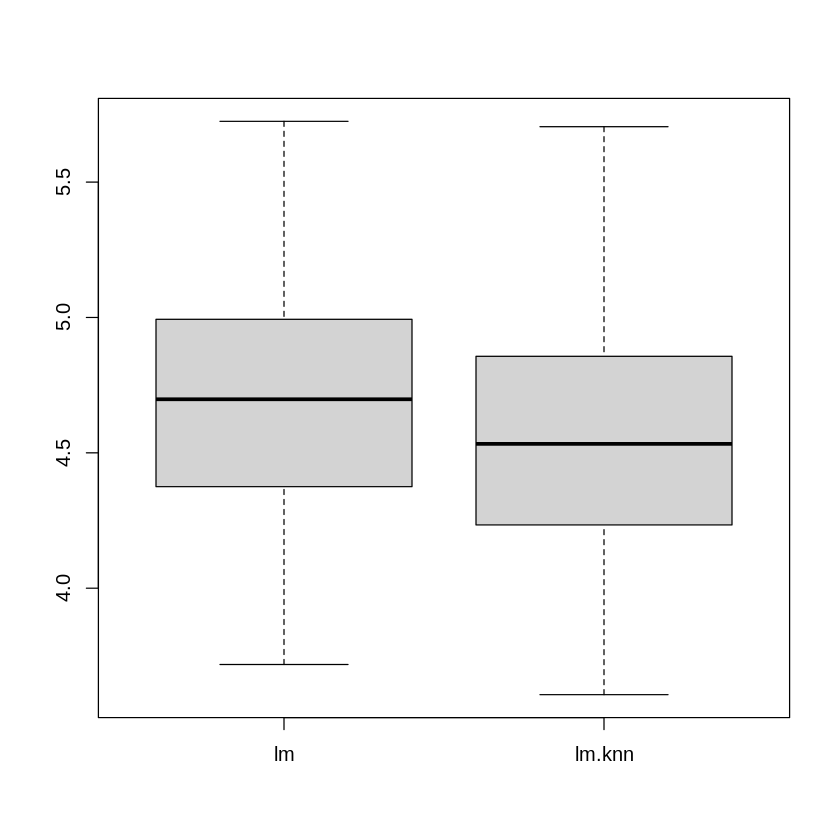

In [9]:
boxplot(data.frame(MSE, MSE_bonus))